# Исследование успешности видеоигр

**Описание проекта**

Для исследования предоставлены данные интернет-магазина, который продает компьютерные игры по всему миру. Из открытых источников собраны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель проекта** - необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Исходные данные** - датасет `/datasets/games.csv`.

Описание данных:
* `Name` — название игры;
* `Platform` — платформа;
* `Year_of_Release` — год выпуска;
* `Genre` — жанр игры;
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий);
* `EU_sales` — продажи в Европе (миллионы проданных копий);
* `JP_sales` — продажи в Японии (миллионы проданных копий);
* `Other_sales` — продажи в других странах (миллионы проданных копий);
* `Critic_Score` — оценка критиков (максимум 100);
* `User_Score` — оценка пользователей (максимум 10);
* `Rating` — рейтинг от организации *ESRB*.

Данные за 2016 год могут быть неполными.

**Краткий план проекта**:
1. Изучить общую информацию о файле; извлечь полезную информацию из датасета; выявить проблемы, требущие обработки данных.
2. Провести предобработку данных, выявленных на предыдущем шаге; добавить необходимую расчетную информацию.
3. Изучить распределение релизов игр по годам и объем продаж в зависимости от платформы; определить актуальный период платформы и выявитиь актуальный период для исследования; отфильтровать исходные данные на основе полученных результатов.
4. Выявить наличие зависимостей между оценками критиков и пользователей и продажами игр.
5. Определить наиболее продаваемые, а значит, популярные жанры игр.
6. Составить портреты пользователей регионов Северная Америка, Европа и Японий. Определить для каждого региона топ-5 платформ, топ-5 жанров и оценить влияние рейтинга *ESRB* на продажи в каждом регионе.
7. Провести статистический анализ и проверить две гипотезы:
- о равенстве средних пользовательских рейтингов платформ *Xbox One* и *PC;
- о равенстве средних пользовательских рейтингов жанров *Action* и *Sports*.
8. Сделать общий вывод по проекту.

## Общая информация о данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Считываем данные из файла и изучаем информацию о датафрейме:

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

### Выводы

Первичный осмотр исходных данных показал, что:
- таблица содержит 16 715 строк и 11 столбцов;
- данные в строках частично отсутствуют;
- колонки (их название и содержимое, где есть текст) необходимо привести к нижнему регистру;
- необходимо преобразовать тип данных: сразу бросается в глаза столбец `year_of_release`, `user_score`;
- нужно рассмотреть 2 пропущенных значения в `name` и `genre` и, возможно, удалить две строки;
- необходимо разобраться с рейтингом *ESRB*;
- следует добавить новый столбец, содержащий данные о глобальных продажах.

## Подготовка данных

### Замена названий столбцов

Заменим названия столбцов, приведя их к нижнему регистру:

In [6]:
data.columns = data.columns.str.lower()

### Изменение регистра данных

Изменим регистр на нижний в тех столбцах, где необходимо: `name`, `platfrom`, `genre`. Для этого воспользуемся простенькой самописной функцией:

In [7]:
def data_lower(row):
    data[row] = data[row].str.lower()

In [8]:
data_lower('name')
data_lower('platform')
data_lower('genre')
data_lower('rating')

### Обработка дубликатов

Проверим, присутствуют ли дубликаты в "полусырых" данных:

In [9]:
print(data.duplicated().sum())

0


### Обработка года выпуска

Обработаем данные в столбце `year_of_release`: удалим пропущенные значения (269 строк из набора 16 000+ не повлияют на результат существенно), преобразуем тип данных с `float64` на `date`:

In [10]:
data.dropna(subset = ['year_of_release'], inplace = True)

In [11]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year

### Пропуски жанров и названий

Обработаем пропущенные значения в столбцах `name` и `genre`. Для начала выведем строки с этими пропущенными значениями:

In [12]:
data[data['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видно, что эти две строки совершенно не информативны для дальнейшего анализа, поэтому без зазрения совести удалим их тоже:

In [13]:
data.dropna(subset = ['genre'], inplace = True)

### Обработка оценок критиков

В столбце `critic_score` содержатся числовые данные с пропущенными значениями. Таких пропусков много - почти 50% от общего числа строк в датафрейме. Данные были получены из открытых источников, возможно, путем парсинга (автоматизированного сбора общедоступной информации из интернета). Тогда возможная причина возникновения пропусков - отсутствие данных либо неидеальная работа парсера.

Поскольку оценки критиков - это субъективные величины, то их заполнение с каким-либо предположением не будет достоверным. Поэтому обработаем их так: заполним пропуски числовыми значениями, но такими, которые однозначно будут выбиваться из общего ряда. При этом нулями заполнять нельзя, так как нули тоже несут в себе полезную информацию. Поэтому заполним пропуски значением -1:

In [14]:
data['critic_score'] = data['critic_score'].fillna(-1)

In [15]:
print('Количество пропусков после заполнения:', data['critic_score'].isnull().sum())

Количество пропусков после заполнения: 0


### Обработка оценок пользователей

In [16]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `user_score` содержатся числовые данные с пропущенными (нулевыми) значениями, а также данные со значением `tbd`. 

Пропусков много - почти 40% от общего числа строк в датафрейме. Возможная причина их возникновения аналогична пропущенным значениям в оценке критиков.

In [17]:
print('Количество значений tbd:', len(data.query('user_score == "tbd"')))

Количество значений tbd: 2376


Строковых данных в этом столбце датафрейма около 12% от общего числа строк. В сфере компьютерных игр сокращение `tbd` означает *to be determined*, то есть *будет определено*. Обычно это касается даты релиза или рейтингов.

В данном случае значения `tbd`, как и значения `NaN`, по сути есть неизвестные значения. Поэтому приведем строковые значения к `NaN`, принудительно преобразовав ошибки в `NaN`:

In [18]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Теперь все пропущенные значения обработаем по аналогии с обработкой оценок критиков:

In [19]:
data['user_score'] = data['user_score'].fillna(-1)

In [20]:
print('Количество пропусков после заполнения:', data['user_score'].isnull().sum())

Количество пропусков после заполнения: 0


### Обработка рейтинга

In [21]:
data['rating'].unique()

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

In [22]:
data['rating'].isnull().sum()

6676

В этом столбце содержатся текстовые данные о рейтинге по системе *Entertainment Software Rating Board (ESRB)*, а также пропущенные значения. Пропущенных значений около 40%, поэтому их нужно будет как-то заполнить. Причина их возникновения скорее всего аналогична изложенной выше.

Рейтинг *ESRB* определяет возрастную категории видеоигры:
- **E** - для всех, то есть для всех от 6 лет и старше;
- **M** - для взрослых, то есть от 17 лет и старше;
- **T** - для подростков, то есть от 13 лет и старше;
- **E10+** - для всех от 10 лет и старше;
- **K-A** - для всех, аналогичен рейтингу **E**, устаревшее обозначение;
- **AO** - только для взрослых, то есть от 18 лет и старше;
- **EC** - для детей младшего возраста, то есть для детей старше 3 лет;
- **RP** - рейтинг ожидается.

In [23]:
data['rating'].value_counts()

e       3921
t       2905
m       1536
e10+    1393
ec         8
k-a        3
rp         1
ao         1
Name: rating, dtype: int64

Заменим **K-A** на **E** как устаревшее обозначение, а **RP** и пропущенным значениям присвоим текстовое обозначение *unknown*:

In [24]:
data.loc[data['rating'] == 'k-a', 'rating'] = "e"
data.loc[data['rating'] == 'rp', 'rating'] = "unknown"
data['rating'] = data['rating'].fillna('unknown')
data['rating'].value_counts()

unknown    6677
e          3924
t          2905
m          1536
e10+       1393
ec            8
ao            1
Name: rating, dtype: int64

### Добавление суммарных продаж

Добавим суммарные продажи в таблице:

In [25]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### Обработанный датафрейм

Рассмотрим датафрейм после всех преобразований:

In [26]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


In [27]:
data.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null float64
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


### Выводы

Проведена обработка данных, необходимых для дальнейшего исследовательского анализа:
* заменены названия столбцов.
* Изменен регистр текстовых данных, содержащихся в таблице.
* Проведена проверка на дубликаты.
* Удалены некоторые значения, которые невозможно заполнить и которые будут искажать результаты анализа.
* Изменены типы данных там, где было необходимо.
* Обработаны пропущенные значения.
* Добавлен столбец глобальных продаж.

## Исследовательский анализ данных

### Количество релизов игр

Оценим, сколько игр выпускалось в разные годы. Для этого создадим сводную таблицу, в которой сгруппируем данные по году выпуска и посчитаем количество игр для каждого года:

In [29]:
releases_per_year = data.pivot_table(
    index = 'year_of_release',
    values='name',
    aggfunc='count'
).reset_index()

Text(0.5, 1.0, 'Количество выпущенных видеоигр за 1980-2016 годы')

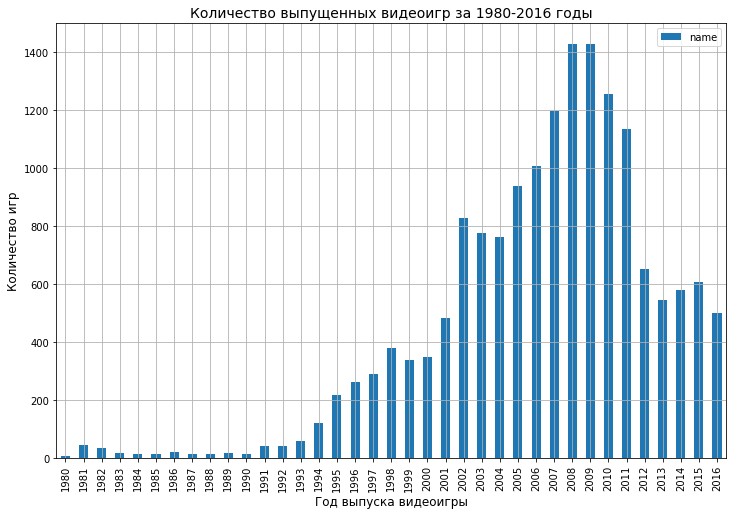

In [30]:
releases_per_year.plot.bar(x='year_of_release', figsize=(12,8), grid=True)
plt.xlabel('Год выпуска видеоигры', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.title('Количество выпущенных видеоигр за 1980-2016 годы', fontsize=14)

По графику видно, что в 80-е годы выпуск видеоигр только набирал обороты и лишь с середины 90-х годов количество релизов значительно возросло. Пик выпущенных видеоигр, согласно представленным данным, пришелся на 2008-2009 годы. Для дальнейшего анализа набор данных за весь период нам не нужен и можно отфильтровать данные по году релиза, оставив диапазон 1995-2016 годы:

In [31]:
data_95 = data.query('year_of_release > 1994')

### Продажи игр в зависимости от платформы

Посмотрим, как менялись продажи по платформам за интересующий нас период, начиная с 1995 года. Для начала оценим топ-10 платформ с наибольшими продажами за весь период, начиная с 1995 года:

In [32]:
platform_sales = data_95.pivot_table(index = 'platform', values='total_sales', aggfunc='sum')

In [33]:
top_platform = platform_sales.sort_values(by = 'total_sales', ascending = False)[:10]

In [34]:
top_platform

,total_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.76
ps,721.55
ps4,314.14
gba,312.88
psp,289.53


Теперь посмотрим, как эти продажи распределялись по годам. Для этого создадим сводную таблицу:

In [35]:
platform_sales_per_year = data_95.pivot_table(
    index='year_of_release', columns='platform', values='total_sales', aggfunc='sum'
).reset_index()

In [36]:
platform_sales_per_year.head()

platform,year_of_release,3do,3ds,dc,ds,gb,gba,gc,n64,ng,...,psv,sat,snes,tg16,wii,wiiu,ws,x360,xb,xone
0,1995,0.08,NaN,NaN,NaN,3.60,NaN,NaN,NaN,0.33,...,NaN,11.57,32.20,0.16,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,NaN,NaN,NaN,NaN,36.03,NaN,NaN,34.10,0.10,...,NaN,7.69,15.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997,NaN,NaN,NaN,NaN,6.37,NaN,NaN,39.50,NaN,...,NaN,6.77,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998,NaN,NaN,3.38,NaN,26.90,NaN,NaN,49.24,NaN,...,NaN,3.82,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999,NaN,NaN,5.16,NaN,38.00,NaN,NaN,57.87,NaN,...,NaN,0.09,0.26,NaN,NaN,NaN,0.46,NaN,NaN,NaN


Отсутствующие значения - это нулевые продажи. Поэтому заменим их нулями:

In [37]:
platform_sales_per_year.fillna(0, inplace = True)

Построим распределение продаж по годам для топ-10 платформ с наибольшими суммарными продажами, которые определены в таблице `top_platform`. Тип распределения - диаграмма с накоплением:

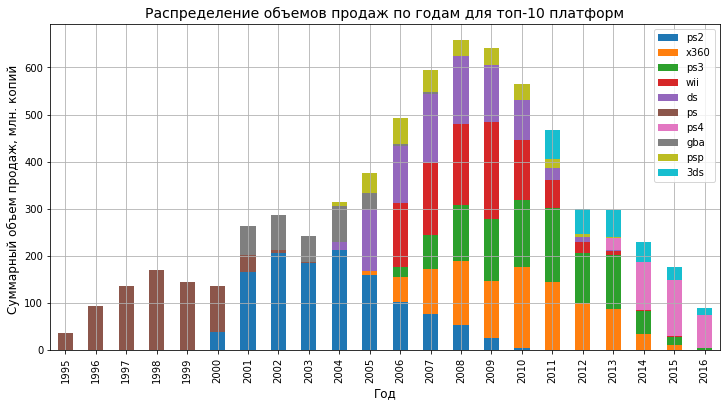

In [38]:
platform_sales_per_year.plot.bar(x='year_of_release', y=top_platform.index, stacked=True, figsize=(12,6), grid=True)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Суммарный объем продаж, млн. копий ", fontsize=12)
plt.legend(top_platform.index)
plt.title("Распределение объемов продаж по годам для топ-10 платформ", fontsize=14)
plt.show()

Из распределения видно, что у платформ есть свой жизненный цикл: платформа появляется, количество проданных копий игр для нее растет, затем идет на спад и исчезает. Определим этот характерный срок: добавим к сводной таблице по объемам продаж столбец `actual`, в котором будет находиться количество ненулевых лет для каждой платформы, и столбец `last_year`, означающий год последнего релиза игры для платформы:

In [39]:
platform_sales.head()

,total_sales
platform,
3do,0.08
3ds,257.81
dc,15.95
ds,802.76
gb,139.90


In [40]:
for platform in platform_sales_per_year.columns:
    platform_sales.loc[platform_sales.index == platform, 'actual'] = \
    platform_sales_per_year.loc[platform_sales_per_year.loc[:, platform] != 0].count()
    platform_sales.loc[platform_sales.index == platform, 'last_year'] = \
    data_95.loc[data_95.loc[:, 'platform'] == platform, 'year_of_release'].max()

In [41]:
platform_sales.head()

,total_sales,actual,last_year
platform,,,
3do,0.08,1.0,1995.0
3ds,257.81,6.0,2016.0
dc,15.95,7.0,2008.0
ds,802.76,10.0,2013.0
gb,139.90,7.0,2001.0


Для полученной таблицы оценим параметры:

In [42]:
platform_sales.describe()

,total_sales,actual,last_year
count,26.000000,26.000000,26.000000
mean,313.650385,7.192308,2007.692308
std,364.780645,4.604513,8.013834
min,0.030000,1.000000,1995.000000
25%,34.852500,4.250000,2001.000000
50%,207.370000,7.000000,2008.000000
75%,313.825000,9.750000,2016.000000
max,1233.560000,22.000000,2016.000000


Видно, что **характерный (медианный) срок жизни платформы составляет 7 лет** для выбранного временного периода 1995-2016 гг.

Однако для дальнейшего анализа и прогнозов будем рассматривать не весь этот период, а половину - полупериод жизни - в качестве актуального. Из графика выше видно, что пик продаж наступает примерно через 3-4 года от появления платформы и такой временной отрезок позволит выявить платформы, которые находятся на пике или имеют растущие продажи, а также платформы с падающими продажами.

Итого: примем за **актуальный период 4 года** (3,5 года с округлением в большую сторону) и соответственно **период с 2012 по 2016 год** для текущего набора данных, поскольку набор данных за 2016 год может быть не полным.

### Расчеты для актуального периода

Определим платформы, которые лидируют по продажам, растут или падают за актуальный период. Для этого сначала найдем платформы, которые актуальны на дату последнего релиза во всем наборе данных:

In [43]:
platform_lifetime = platform_sales['actual'].median()
max_year = data_95['year_of_release'].max()

In [44]:
platform_sales_actual = platform_sales.query('last_year == @max_year').sort_values(by = 'total_sales', ascending=False)
platform_sales_actual

,total_sales,actual,last_year
platform,,,
x360,961.24,12.0,2016.0
ps3,931.34,11.0,2016.0
wii,891.18,11.0,2016.0
ps4,314.14,4.0,2016.0
3ds,257.81,6.0,2016.0
pc,239.79,22.0,2016.0
xone,159.32,4.0,2016.0
wiiu,82.19,5.0,2016.0
psv,53.81,6.0,2016.0


Извлечем список платформ:

In [45]:
print('Список актуальных платформ:', platform_sales_actual.index.tolist())

Список актуальных платформ: ['x360', 'ps3', 'wii', 'ps4', '3ds', 'pc', 'xone', 'wiiu', 'psv']


Отфильтруем сводную таблицу продаж для платформ по годам `platform_sales_per_year` для созданного списка действующих на последний (самый свежий) год в соответствии с актуальным периодом:

In [46]:
platform_sales_per_year = platform_sales_per_year[
    platform_sales_per_year['year_of_release'] >= (max_year - np.ceil(platform_lifetime / 2))
].reset_index(drop=True)

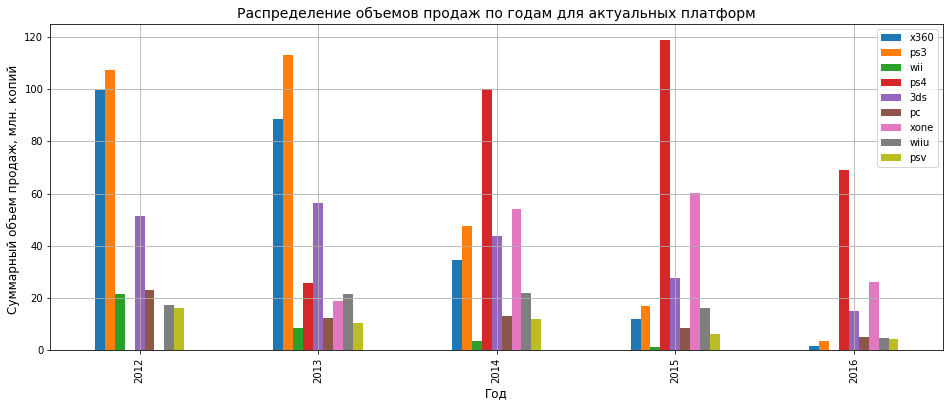

In [47]:
platform_sales_per_year.plot.bar(x='year_of_release', y=platform_sales_actual.index, figsize=(16,6), grid=True)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Суммарный объем продаж, млн. копий ", fontsize=12)
plt.legend(platform_sales_actual.index)
plt.title("Распределение объемов продаж по годам для актуальных платформ", fontsize=14)
plt.show()

Из графика видно, какие платформы лидируют по продажам, растут или падают:
- в конце своего жизненного цикла находятся `x360`, `ps3`, `wii`;
- падают `pc`, `psv`, `3ds`, `wiiu`;
- на пике продаж находится `ps4` и `xone`.

Полученное распределение позволяет сделать вывод, что на смену платформам `x360`, `ps3`, `wii`, `pc`, `psv`, `wiiu` пришли `ps4` и `xone`. А на последний год наиболее популярными являются платформы `3ds`, `ps4` и `xone`.

Именно их определим как **наиболее перспективные: `ps4`, `xone` и `3ds`.** И добавим к ним медленно падающие платформы `wiiu`, `pc`.

### Ящик с усами и актуальный датасет

Создадим датафрейм `data_analysis` с учетом актуального периода:

In [48]:
perspective_platform = ['ps4', 'xone', '3ds', 'pc', 'wiiu']
actual_year = max_year - np.ceil(platform_lifetime / 2)

In [49]:
data_analysis = data.query('(year_of_release >= @actual_year)').reset_index(drop=True)

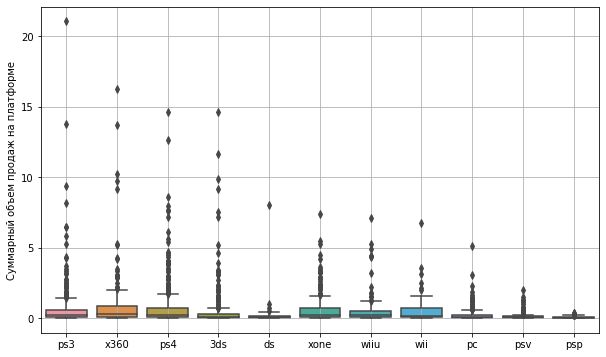

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='total_sales', data=data_analysis)
plt.grid()
plt.xlabel('')
plt.ylabel('Суммарный объем продаж на платформе')
plt.title('')
plt.show()

На графике выше хорошо видны выбросы для платформ в отфильтрованном для актуального периода датафрейма. Чтобы лучше рассмотреть сами ящики, укоротим вертикальную ось:

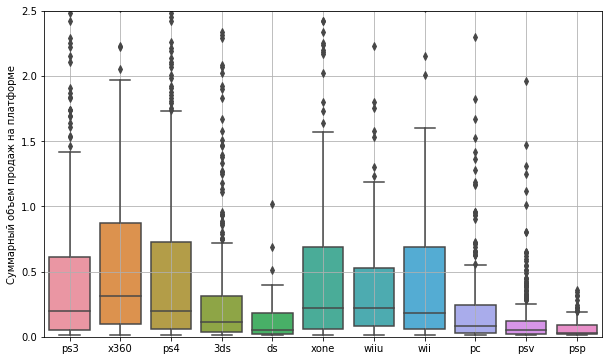

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='total_sales', data=data_analysis)
plt.ylim([0, 2.5])
plt.grid()
plt.xlabel('')
plt.ylabel('Суммарный объем продаж на платформе')
plt.title('')
plt.show()

По распределениям для всех платформ, живущих в актуальном периоде, можно сказать, что:
- плафтормы, которые мы определили как перспективные, показывают наилучшие результаты по объему продаж;
- наибольшую медиану имеет платформа `x360` и наибольший ус;
- медианы и межквартильный размах для платформ `ps4`, `wii` и `xone` сопоставимы; это означает, что 50% игр приносит для них обоих почти одинаковую прибыль и чуть меньше приносит `wiiu`;
- платформа `3ds`, несмотря на довольно узкий "ящик", имеет много выбросов, как и `ps4`, `ps3`; это говорит о том, что у этих платформ значительное число игр-бестселлеров ("выбросов"), сильно выбивающихся по продажам по сравнению с большинством игр;
- платформы `psp` и `ds` наиболее мелкие по объемам продаж среди платформ и почти не имеют игр-бестселлеров.

### Зависимость продаж и отзывов

Изучим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Рассмотрим в качестве популярной платформы `ps4`. Для вычисления коэффициента корреляции и построения диаграмм рассеяния напишем собственную функцию:

In [52]:
def corr_score_sales(pl_type, scores1, scores2=None):
    print('Платформа ' + str(pl_type) + ':')
    for column in [scores1, scores2]:
        sample = data_analysis.query('(platform == @pl_type) and (user_score != -1) and (critic_score != -1)')
        coef = sample['total_sales'].corr(sample[column])
        print(f'Коэффициент корреляции для столбца {column} равен {coef:.2f}.')
        if column == 'user_score':
            sample.plot(x=column, y='total_sales', kind='scatter', alpha=0.5, figsize=(10,3), color='indigo')
            plt.xlabel('Оценка пользователей', fontsize=10)
            plt.title('Диаграмма рассеяния оценок пользователей', fontsize=12)
        if column == 'critic_score':
            sample.plot(x=column, y='total_sales', kind='scatter', alpha=0.5, figsize=(10,3), color='tomato')
            plt.xlabel('Оценка критиков', fontsize=10)
            plt.title('Диаграмма рассеяния оценок критиков', fontsize=12)
        plt.ylabel('Суммарный объем продаж на платформе', fontsize=10)
        plt.grid()
        plt.show()

Платформа ps4:
Коэффициент корреляции для столбца critic_score равен 0.41.


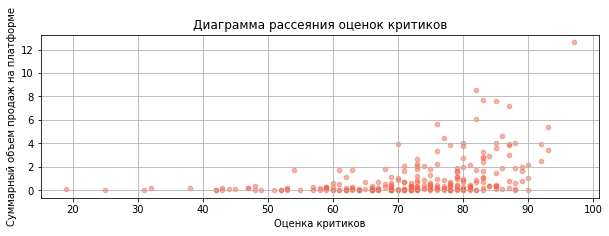

Коэффициент корреляции для столбца user_score равен -0.03.


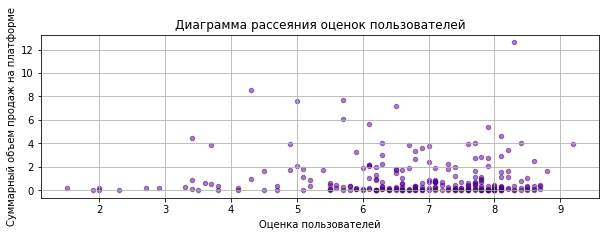

In [53]:
corr_score_sales('ps4', 'critic_score', 'user_score')

Коэффициент корреляции между продажами и отзывами критиков равен 0.41, что говорит о несильной положительной линейной связи. Это означает, что чем выше оценка критиков, тем выше продажи, но так происходит далеко не всегда. А вот между оценкой пользователей и продажами вообще нет никакой связи.

Оценим взаимосвязь между продажами и отзывами для других популярных платформ:

Платформа 3ds:
Коэффициент корреляции для столбца critic_score равен 0.31.


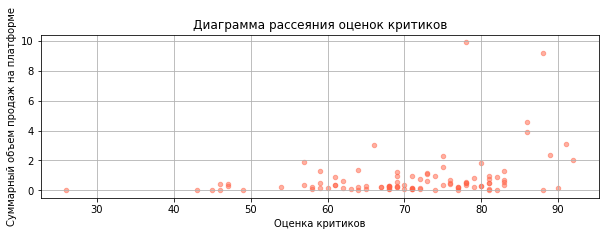

Коэффициент корреляции для столбца user_score равен 0.20.


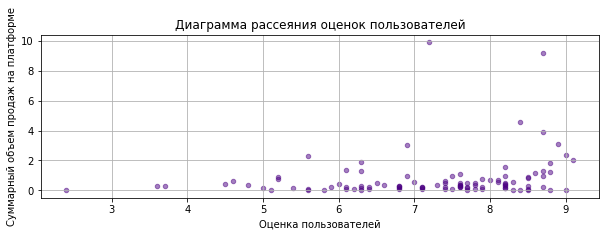

Платформа xone:
Коэффициент корреляции для столбца critic_score равен 0.41.


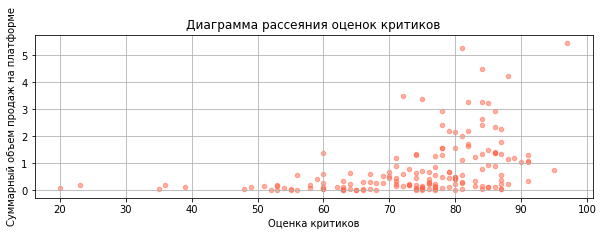

Коэффициент корреляции для столбца user_score равен -0.09.


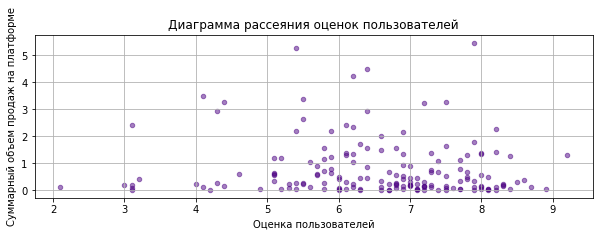

Платформа wiiu:
Коэффициент корреляции для столбца critic_score равен 0.35.


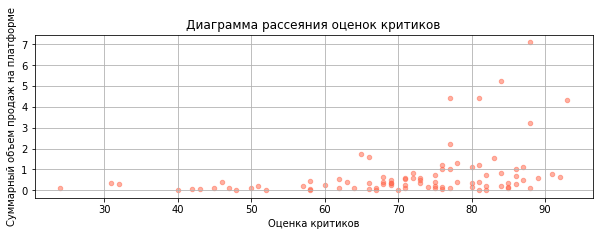

Коэффициент корреляции для столбца user_score равен 0.39.


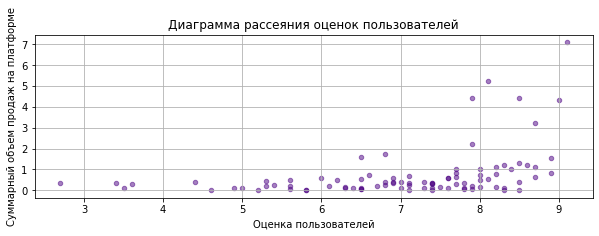

Платформа pc:
Коэффициент корреляции для столбца critic_score равен 0.24.


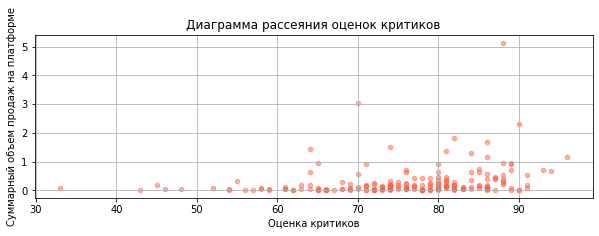

Коэффициент корреляции для столбца user_score равен -0.14.


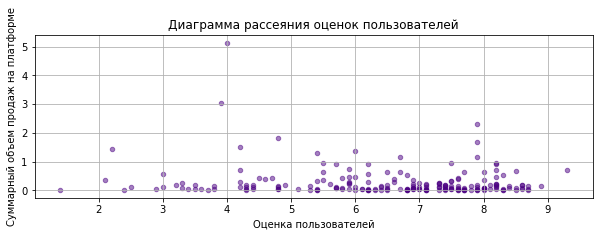

In [54]:
corr_score_sales('3ds', 'critic_score', 'user_score')
corr_score_sales('xone', 'critic_score', 'user_score')
corr_score_sales('wiiu', 'critic_score', 'user_score')
corr_score_sales('pc', 'critic_score', 'user_score')

Для четырех других популярных платформ выводы о линейной взаимосвязи между отзывами критиков и пользователей и продажами остаются также верными.

Обобщая, можно сказать, что для платформ `xone`, `ps4`, `pc` не будет лишним ориентироваться на отзывы критиков, для платформ `wiiu` и `3ds` - и на отзывы критиков, и на отзывы пользователей, при этом для платформы `wiiu` чуть большее значение приобретают отзывы пользователей, а не критиков.

### Распределение игр по жанрам

Сгруппируем данные за актуальный период по жанрам и построим диаграмму распределения:

Text(0.5, 1.0, 'Количество проданных игр по жанрам за актуальный период')

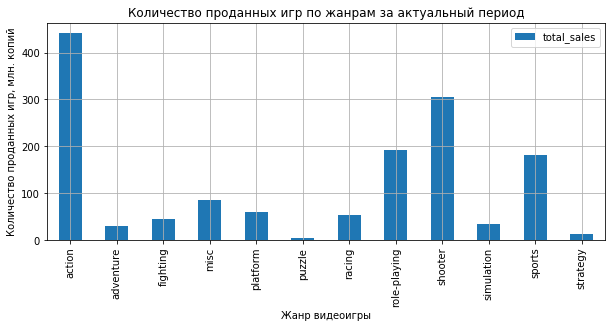

In [55]:
data_analysis.pivot_table(index='genre', values='total_sales', aggfunc='sum').plot.bar(figsize=(10,4), grid=True)
plt.xlabel('Жанр видеоигры')
plt.ylabel('Количество проданных игр, млн. копий')
plt.title('Количество проданных игр по жанрам за актуальный период')

Всего в датафрейме за актуальный период для перспективных платформ содержатся игры 12 жанров, среди которых наиболее прибыльными являются игры жанров топ-5: *action*, *shooter*, *role-playing*, *sports* и *misc*.

Чтобы сравнить наиболее популярные жанры с остальными по объему продаж, построим их распределения в виде "ящиков с усами":

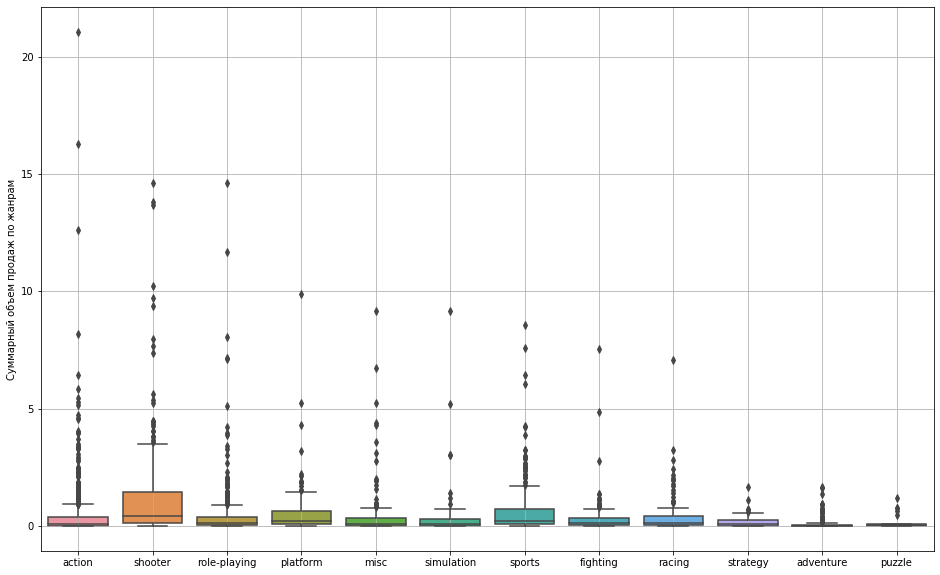

In [56]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='genre', y='total_sales', data=data_analysis)
plt.grid()
plt.xlabel('')
plt.ylabel('Суммарный объем продаж по жанрам')
plt.title('')
plt.show()

Добавим второй такой же график, чтобы поближе рассмотреть сами ящики:

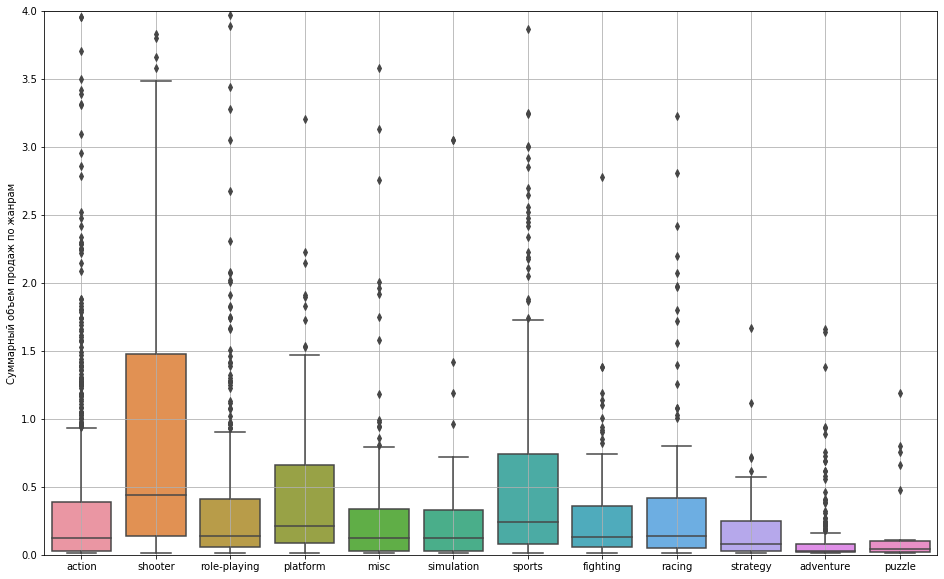

In [57]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='genre', y='total_sales', data=data_analysis)
plt.ylim([0, 4])
plt.grid()
plt.xlabel('')
plt.ylabel('Суммарный объем продаж по жанрам')
plt.title('')
plt.show()

По полученным распределениям для разных жанров можно сказать, что:
- наиболее продаваемыми являются игры жанров топ-5, как и показала диаграмма выше;
- среди них безусловный лидер - *shooter*, который имеет наибольшую дисперсию;
- у игр жанров *action* и *role-playing* большой объем продаж составляют игры-бестселлеры ("выбросы");
- хуже всего в актуальном периоде продаются игры *puzzle* и *adventure*.

### Выводы

* Исследовательский анализ данных показал, что датасет содержит данные о видеоиграх с 1980 по 2016 год. Однако весь набор данных не интересен для анализа, поскольку до середины 90-х рынок компьютерных игр только набирал обороты. Был отфильтрован временной период 1995-2016 гг.
* Распределение количества релизов игр по годам показало, что у платформ есть свой жизненный цикл. Характерный (медианный) срок жизни платформы составляет 7 лет для выбранного временного периода 1995-2016 гг.
* Для дальнейшего анализа и прогнозов был принят именно этот срок в качестве актуального (7 лет) и период с 2010 по 2016 год для текущего набора данных соответственно.
* Был выделен топ-10 самых популярных платформ, в тройке лидеров: `ps2`	с 1,2 млрд проданных копий игр, затем с небольшой разницей `x360` с 0,96 млрд и `ps3` с 0,93 млрд проданных копий за период 1995-2016 гг.
* Анализ объемов продаж по платформам показал, что наиболее перспективными платформами можно назвать `ps4`, `xone`, `3ds`, `wiiu`, `pc`.
* По распределениям суммарных объемов продаж для перспективных платформ было выявлено, что у этих платформ имеется значительное число игр-бестселлеров.
* Изучение влияния отзывов критиков и пользователей на продажи показало, что для платформ `xone`, `ps4`, `pc` не будет лишним ориентироваться на отзывы критиков, для платформ `wiiu` и `3ds` - и на отзывы критиков, и на отзывы пользователей, при этом для платформы `wiiu` чуть большее значение приобретают отзывы пользователей, а не критиков.
* Был определен топ-5 наиболее популярных жанров: `action`, `shooter`, `role-playing`, `sports` и `misc`. Хуже всего в актуальном периоде продаются игры жанров `puzzle` и `adventure`.

## Портрет пользователя каждого региона

### Популярные платформы по регионам

Проанализируем, как меняются доли платформ в зависимости от региона, выделив топ-5 платформ. Для этого напишем собственную функцию, которая будет создавать сводные таблицы и строить по ним круговые диаграммы:

In [58]:
def platform_for_region(region_sales, platform):
    fig, axs = plt.subplots(1, len(region_sales), figsize=(20, 6))
    i = 0
    for region in region_sales:
        df = data_analysis.pivot_table(index = platform, values = region, aggfunc = 'sum')
        df = df[df[region] > 0].sort_values(by=region, ascending=False)[:5]
        pie = df.plot(ax=axs[i], y=region, autopct='%1.1f%%', pctdistance=0.8, radius=1.2, kind='pie', startangle = 180)
        pie.legend().remove()
        pie.set_title(region)
        i += 1
        pie.set_ylabel(None)
    plt.suptitle('Доля объема продаж по платформам', fontsize=16)
    plt.show()

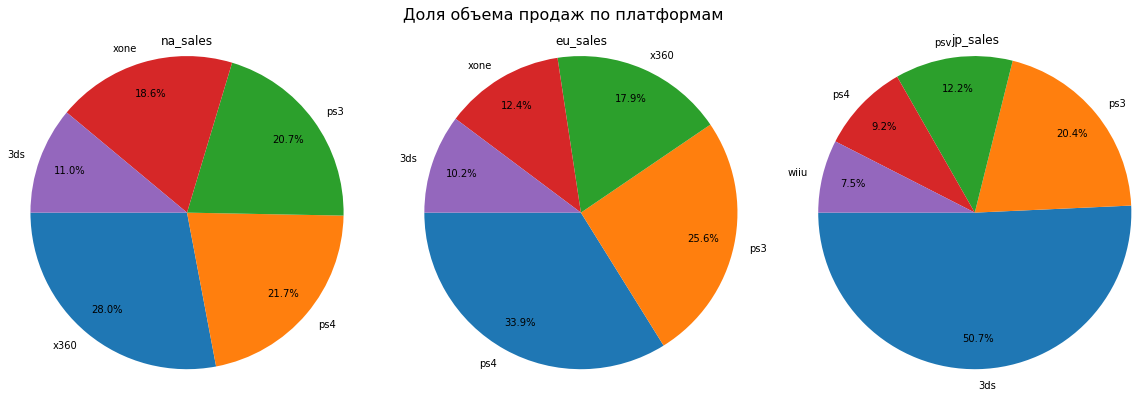

In [59]:
region_sales = ['na_sales', 'eu_sales', 'jp_sales']
platform_for_region(region_sales, 'platform')

Распределение продаж по платформам различается по регионам:
- в Северной Америке наиболее популярна платформа `x360` (28%), затем `ps4` (22%) и `ps3` (21%);
- в Европе наибольшие продажи обеспечивает платформа `ps4` (34%), затем `ps3` (26%), следом `x360` (18%);
- в Японии лидирующую позицию занимает платформа `3ds` (51%), следом  `ps3` (21%).


### Популярные жанры по регионам

Проанализируем, как меняются доли популярных жанров видеоигр (топ-5) в зависимости от региона. Для этого напишем собственную функцию, которая будет создавать сводные таблицы и строить по ним круговые диаграммы:

In [60]:
def genre_for_region(region_sales):
    fig, axs = plt.subplots(1, len(region_sales), figsize=(20, 6))
    i = 0
    for region in region_sales:
        df = data_analysis.pivot_table(index = 'genre', values = region, aggfunc = 'sum')
        df = df[df[region] > 0].sort_values(by = region, ascending = False)[:5]
        pie = df.plot(ax=axs[i], y=region, autopct='%1.1f%%', pctdistance=0.8, radius=1.2, kind='pie', startangle = 180)
        pie.legend().remove()
        pie.set_title(region)
        i += 1
        pie.set_ylabel(None)
    plt.suptitle('Доля объема продаж по жанрам', fontsize=16)
    plt.show()

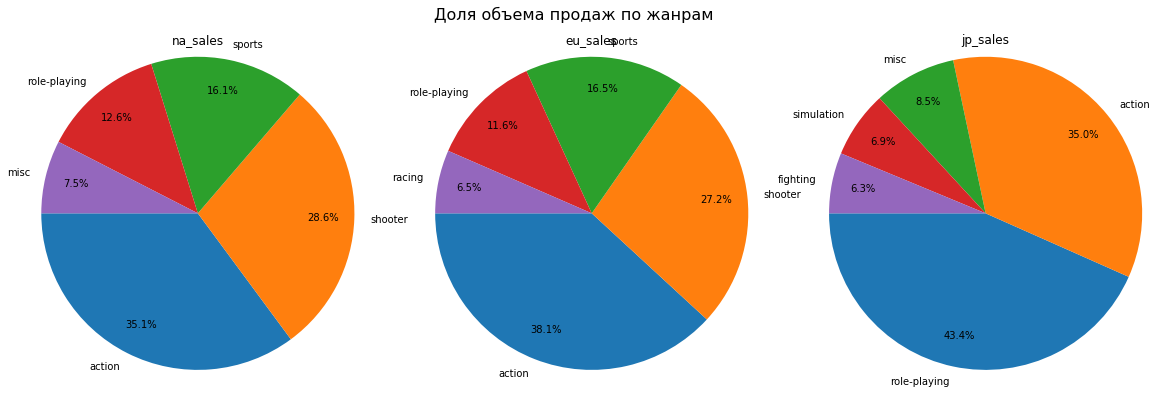

In [61]:
genre_for_region(region_sales)

По популярности жанров Северная Америка и Европа очень похожи. Отдельные жанры занимают следующие доли:
- `action` около 35-38%;
- `shooter` около 27-28%;
- `sports` около 16%;
- `role-playing` около 12-13%;
- остальные 7-8% делятся между `misc` (NA) и `racing` (EU).

В Японии ситуация, как и в случае с платформами, иная: есть один самый популярный жанр `role-playing` (44%), затем второй по популярности жанр `action` (35%), а остальные 20% делятся между `fighting`, `simulation`, `misc`.

### Рейтинг ESRB по регионам

По аналогии оценим влияние рейтинга по регионам с помощью пользовательской функции:

In [62]:
def rating_for_region(region_sales):
    fig, axs = plt.subplots(1, len(region_sales), figsize=(20, 6))
    i = 0
    for region in region_sales:
        df = data_analysis.pivot_table(index = 'rating', values = region, aggfunc = 'sum')
        df = df[df[region] > 0].sort_values(by = region, ascending = False)[:5]
        pie = df.plot(ax=axs[i], y=region, autopct='%1.1f%%', pctdistance=0.8, radius=1.2, kind='pie', startangle = 180)
        pie.legend().remove()
        pie.set_title(region)
        i += 1
        pie.set_ylabel(None)
    plt.suptitle('Доля объема продаж по рейтингу ESRB', fontsize=16)
    plt.show()

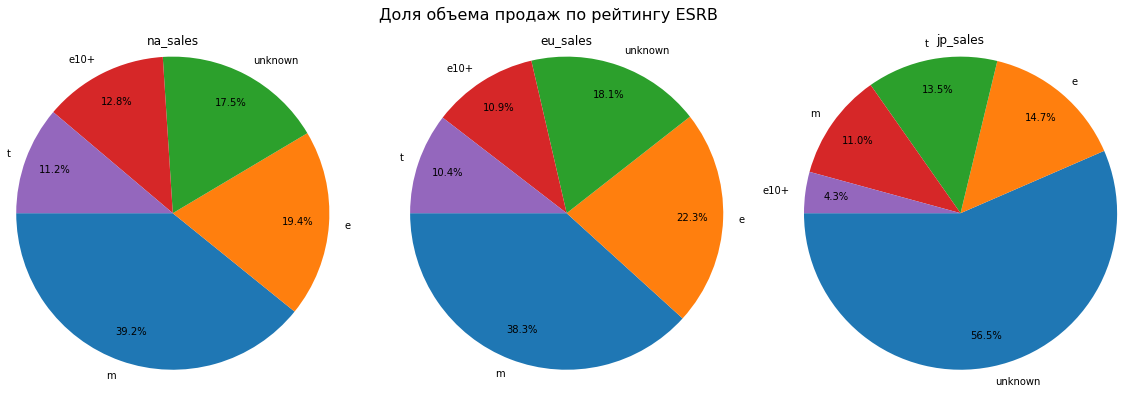

In [63]:
rating_for_region(region_sales)

Снова наблюдаем похожие распределения для Северной Америки и Европы и резкое отличие для Японии.
* В первом случае наиболее популярны игры с рейтингом **M** (возраст 17+) (38-39%), затем **E** (для всех возрастных категорий) (19-22%), затем игры неизвестного жанра (17-18%), после **E10+** (возраст 10+) (11-12%) и в конце **T** (возраст 13+) (10-11%).
* В Японии же на первом месте находятся игры неизвестного рейтинга (57%), затем **E** (для всех возрастных категорий) (15%),  **T** (возраст 13+) (14%), **M** (возраст 17+) (11%) и **E10+** (возраст 10+) (5%).

Вопрос о 57% данных с неизвестным рейтингом по Японии следует выяснить.

### Выводы

* Был составлен портрет пользователей трех регионов: Северная Америка, Европа и Азия.
* В Северной Америке и Европе наиболее популярны платформы `x360`, `ps4` и `ps3`, отличаются только их распределение по местам в этом топ-3. В Японии лидирующую позицию занимает платформа `3ds`, обеспечивая половину объема продаж.
* По популярности жанров Северная Америка и Европа очень похожи: больше всего продается игр `action` и `shooter`. В Японии же самый популярный жанр `role-playing`, второй по популярности жанр `action`.
* По возрастному рейтингу распределения для Северной Америки и Европы схожи, а для Японии снова резкое отличие: в Европе и Америке наиболее популярны игры для возраста 17+, а затем для всех возрастных категорий; в Японии же на первом месте находятся игры неизвестного рейтинга (58%), затем для всех возрастных категорий. Вопрос с неизвестным рейтингом следует дополнительно прояснить.

## Проверка гипотез

### Рейтинги Xbox One и PC одинаковые

Проверим гипотезу о том, что средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые.

Для этого сформулируем нулевую гипотезу H0: средние пользовательские рейтинги платформ *Xbox One* и *PC* равны.

Тогда альтернативная гипотеза H1 будет звучать так: средние пользовательские рейтинги платформ *Xbox One* и *PC* отличаются.

Создадим два объекта `series`, содержащих данные о средних пользовательских рейтингах двух платформ:

In [64]:
sample_xbox = data_analysis.query('(platform == "xone") and (user_score != -1) and (critic_score != -1)')['user_score']

In [65]:
sample_pc = data_analysis.query('platform == "pc"and (user_score != -1) and (critic_score != -1)')['user_score']

Оценим дисперсии двух выборок. Если дисперсии будет отличаться более чем на 5%, то будем считать, что генеральные совокупности, из которых взяты эти выборки, отличаются по параметрам и тогда будем задавать в функции `st.ttest_ind` параметр `equal_var=False`.

In [66]:
variance_sample_xbox = np.var(sample_xbox, ddof=1).round(2)
variance_sample_pc = np.var(sample_pc, ddof=1).round(2)
print('Дисперсия выборки sample_xbox:', variance_sample_xbox)
print('Дисперсия выборки sample_pc:', variance_sample_pc)
diff = (variance_sample_xbox - variance_sample_pc) * 100 / variance_sample_xbox
print(f'Дисперсии двух выборок отличаются на {abs(diff):.2f}%')

Дисперсия выборки sample_xbox: 1.8
Дисперсия выборки sample_pc: 2.69
Дисперсии двух выборок отличаются на 49.44%


Зададим пороговое значение *alpha* равным 0.05. Это означает, что будем проверять гипотезу о равенстве средних значений этих выборок на 95% уровне доверия:

In [67]:
alpha = 0.05

Воспользуемся встроенными в *Python* функциями для проверки статистических гипотез:

In [68]:
results = st.ttest_ind (sample_xbox, sample_pc, equal_var=False)

In [69]:
print('p-значение:', results.pvalue)

p-значение: 0.5926561176517491


In [70]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Не получилось отвергнуть нулевую гипотезу


Результаты статистического анализа показали, что при 5% уровне значимости нулевая гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC не отвергается. Это означает, что *средние пользовательские рейтинги по двум платформам с вероятностью 60% будут иметь схожие значения*.

### Рейтинги жанров Actions и Sports разные

Проверим гипотезу о том, что средние пользовательские рейтинги жанров *Action* и *Sports* разные.

Для этого сформулируем нулевую гипотезу H0: средние пользовательские рейтинги жанров *Action* и *Sports* равны.

Тогда альтернативная гипотеза H1 будет звучать так: средние пользовательские рейтинги жанров *Action* и *Sports* отличаются.

Создадим два объекта `series`, содержащих данные о средних пользовательских рейтингах двух платформ:

In [71]:
sample_action = data_analysis.query('genre == "action" and (user_score != -1) and (critic_score != -1)')['user_score']

In [72]:
sample_sports = data_analysis.query('genre == "sports" and (user_score != -1) and (critic_score != -1)')['user_score']

Оценим дисперсии двух выборок. Если дисперсии будет отличаться более чем на 5%, то будем считать, что генеральные совокупности, из которых взяты эти выборки, отличаются по параметрам и тогда будем задавать в функции `st.ttest_ind` параметр `equal_var=False`.

In [73]:
variance_sample_action = np.var(sample_action, ddof=1).round(2)
variance_sample_sports = np.var(sample_sports, ddof=1).round(2)
print('Дисперсия выборки sample_action:', variance_sample_action)
print('Дисперсия выборки sample_sports:', variance_sample_sports)
diff = (variance_sample_action - variance_sample_sports) * 100 / variance_sample_action
print(f'Дисперсии двух выборок отличаются на {abs(diff):.2f}%')

Дисперсия выборки sample_action: 1.75
Дисперсия выборки sample_sports: 1.99
Дисперсии двух выборок отличаются на 13.71%


Зададим пороговое значение *alpha* равным 0.05. Это означает, что будем проверять гипотезу о равенстве средних значений этих выборок на 95% уровне доверия:

In [74]:
alpha = 0.05

Воспользуемся встроенными в *Python* функциями для проверки статистических гипотез:

In [75]:
results = st.ttest_ind (sample_action, sample_sports, equal_var=False)

In [76]:
print('p-значение:', results.pvalue)

p-значение: 5.858072645452818e-14


In [77]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


Результаты статистического анализа показали, что при 5% уровне значимости нулевая гипотеза о равенстве средних пользовательских рейтингов жанров *Action* и *Sports* отвергается. Это означает, что *средние пользовательские рейтинги по двум жанрам существенно отличаются* и, если бы мы утверждали, что средние рейтинги равны, то ошибались бы в 95% случаев.

### Выводы

* С помощью статистического анализа были проверены две гипотезы с уровнем значимости *alpha* = 5%.
* Первая нулевая гипотеза состояла в том, что средние пользовательские рейтинги платформ *Xbox One* и *PC* равны. По результатам исследования эта нулевая гипотеза не была отвергнута. Это означает, что средние пользовательские рейтинги по двум платформам с вероятностью 99% будут иметь схожие значения.
* Вторая нулевая гипотеза состояла в том, что средние пользовательские рейтинги жанров *Action* и *Sports* равны. По результатам исследования эта нулаевая гипотеза была отвергнута. Это означает, что средние пользовательские рейтинги по двум жанрам существенно отличаются и, если бы мы утверждали, что средние рейтинги равны, то ошибались бы в 95% случаев.

## Общий вывод

1. Целью проекта было выявить закономерности, определяющие успешность компьютерных игр, с тем, чтобы для любого года можно было сделать ставку на потенциально популярный продукт, основываясь на исторических данных за некоторый актуальный период.
2. Было обнаружено, что платформы имеют свой жизненный цикл, в среднем длящийся 7 лет. Половина этой длительности была выбрана в качестве актуального периода и может использоваться для дальнейших прогнозов.
3. Анализ данных показал, что успех компьютерных игр зависит от многих параметров и нет одного или двух однозначно определяющих параметров.

**При составлении прогноза и определении потенциально популярных продуктов на 2017 год следует принять во внимание следующее**:
- игра должна находиться в списке популярных платформ: *ps4*, *xone*, *3ds*, *wiiu*, *pc*;
- желательно в одном из популярных жанров: *action*, *shooter*, *role-playing*, *sports* и *misc*;
- иметь отличные рейтинги от критиков;
- иметь возрастной рейтинг *E* или *M*.

**Обязательно нужно учитывать географическую специфику рынка:**
- в Северной Америке и Европе наиболее популярны платформы *x360*, *ps4* и *ps3*, в Японии лидирующую позицию занимает платформа *3ds*;
- в Северной Америке и Европе наиболее популярны игры жанров *action* и *shooter*, в Японии - *role-playing* и *action*;
- в Северной Америке и Европе по возрастному рейтингу наиболее популярны игры для возраста 17+, в Японии - для всех возрастных категорий.